# Import Modules

In [1]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
import random
import os
from shapely.geometry import Point

pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings("ignore")

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

# Seeding

In [2]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Old Wheat

## Importing Files and basic characteristic check

In [3]:
# Old wheat 

xlsx = pd.ExcelFile(r'data_files/new+old/old/Wheat_Signature.xlsx')
oct_2f = pd.read_excel(xlsx, 'W_Oct_2Fn_sowing')
nov_1f = pd.read_excel(xlsx, 'W_Nov_1fn_sowing')
nov_2f = pd.read_excel(xlsx, 'W_Nov_2fn_sowing')
dec_1f = pd.read_excel(xlsx, 'W_Dec_1Fn_sowing')
dec_2f = pd.read_excel(xlsx, 'W_Dec_2Fn_sowing')

wheat_dfs = [oct_2f, nov_1f, nov_2f, dec_1f, dec_2f]
target_cols = ['latitude', 'longitude', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f']

i = 0

wheat = pd.DataFrame(columns=target_cols)
for dfs in wheat_dfs:
    dfs = dfs.drop(['FID'], axis=1)
    dfs.columns = target_cols
    wheat = pd.concat([wheat, dfs])
    i += 1
    
wheat.head(3)

,latitude,longitude,district,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f
0,23.221024,75.548143,UJJAIN,117,154,185,186,191,191,185,177,131,120,114,120
1,22.749243,76.285961,DEWAS,118,153,172,182,189,181,173,157,124,118,113,112
2,22.823677,75.178438,DHAR,119,159,186,190,193,191,178,144,122,117,113,114


In [4]:
# Some Wheat found in Non_wheat

xlsx = pd.ExcelFile('data_files/new+old/old/crop_profiles.xlsx')
non_wheat = pd.read_excel(xlsx, 'crop')

display('raw:', non_wheat.head(3), non_wheat.shape)

wheat_frm_nw = non_wheat[non_wheat.Crop_Nam_1 == 'Wheat']

wheat_frm_nw.drop(['FID', 'Crop_Nam_1', 'STATE_NAME'], axis=1, inplace=True)
wheat_frm_nw.columns = ['latitude', 'longitude', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f']


wheat = pd.concat([wheat, wheat_frm_nw], ignore_index=True)

# New column values
new_columns = {'state_name': [['Madhya Pradesh'] * wheat.shape[0], 2],
               'taluka_name': [[np.nan] * wheat.shape[0], 4],
              'crop_name': [['Wheat'] * wheat.shape[0], 17]}

for cols in new_columns.keys():
    wheat.insert(new_columns[cols][1], cols, new_columns[cols][0])

display('cleaned: ', wheat.head(), wheat.shape)

'raw:'

,FID,lat,long,Crop_Nam_1,STATE_NAME,DISTRICT,Oct_2FN,Nov_1FN,Nov_2FN,Dec_1FN,Dec_2FN,Jan_1FN,Jan_2FN,Feb_1Fn,Feb_2Fn,Mar_1Fn,Mar_2Fn,Apr_1fn
0,66,26.275699,77.317284,2 Mustard,Madhya Pradesh,MORENA,117,130,183,186,183,188,184,184,165,131,165,180
1,819,26.235858,77.446783,2 Mustard,Madhya Pradesh,MORENA,121,151,190,191,188,186,189,187,168,138,149,171
2,1219,24.970808,75.246897,2 Mustard,Madhya Pradesh,NIMACH,142,174,178,181,180,177,163,129,135,138,145,171


(1581, 18)

'cleaned: '

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name
0,23.221024,75.548143,Madhya Pradesh,UJJAIN,NaN,117,154,185,186,191,191,185,177,131,120,114,120,Wheat
1,22.749243,76.285961,Madhya Pradesh,DEWAS,NaN,118,153,172,182,189,181,173,157,124,118,113,112,Wheat
2,22.823677,75.178438,Madhya Pradesh,DHAR,NaN,119,159,186,190,193,191,178,144,122,117,113,114,Wheat
3,22.823894,75.178496,Madhya Pradesh,DHAR,NaN,119,158,186,190,193,191,178,146,121,119,117,116,Wheat
4,23.746600,78.178934,Madhya Pradesh,VIDESHA,NaN,119,151,184,190,189,188,186,170,132,121,113,112,Wheat


(16904, 18)

In [5]:
def int_check(val):
    try:
        val = int(val)
    except:
        return True
    return False

# Checking if any of the ndvi values are non numeric.
for cols in wheat.loc[:,'oct_2f':'apr_1f'].columns:
    print(wheat[cols].apply(int_check).sum(), end=' ')

# Converting all fortnight columns to integer
for cols in wheat.loc[:,'oct_2f':'apr_1f'].columns:
    wheat[cols] = wheat[cols].astype(int)
    
display(wheat.dtypes)

0 0 0 0 0 0 0 0 0 0 0 0 

latitude       float64
longitude      float64
state_name      object
district        object
taluka_name    float64
oct_2f           int64
nov_1f           int64
nov_2f           int64
dec_1f           int64
dec_2f           int64
jan_1f           int64
jan_2f           int64
feb_1f           int64
feb_2f           int64
mar_1f           int64
mar_2f           int64
apr_1f           int64
crop_name       object
dtype: object

## Data cleaning and EDA

In [32]:
outliers = wheat[wheat.loc[:,'oct_2f':'dec_2f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]

# Rows which have 0s or 1s in the 5 possible sowing periods for wheat are dropped
wheat.drop(outliers.index, inplace=True)

display(f'{outliers.shape[0]} dropped', wheat.loc[:,'oct_2f':'apr_1f'].describe().T)

'9 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,16895.0,146.390056,16.649027,83.0,133.0,144.0,159.0,200.0
nov_1f,16895.0,129.697366,12.973034,93.0,120.0,126.0,136.0,190.0
nov_2f,16895.0,127.309973,9.412195,109.0,121.0,126.0,131.0,200.0
dec_1f,16895.0,141.780882,18.372175,110.0,127.0,136.0,156.0,200.0
dec_2f,16895.0,168.419710,16.296510,118.0,157.0,171.0,182.0,200.0
jan_1f,16895.0,181.456230,9.640751,1.0,177.0,183.0,188.0,200.0
jan_2f,16895.0,184.001243,6.746694,121.0,181.0,185.0,188.0,200.0
feb_1f,16895.0,186.334714,6.342976,118.0,184.0,187.0,190.0,200.0
feb_2f,16895.0,181.827996,11.562908,116.0,180.0,185.0,189.0,200.0
mar_1f,16895.0,164.181415,21.166705,89.0,148.0,172.0,181.0,200.0


In [34]:
def harvest_avg_impute(row):
    lst = deepcopy(row)
    hrvst_strt_idx = lst.index.get_loc('jan_2f')
    for i in range(len(lst.loc['jan_2f':'mar_2f'])):
        actual_idx = i + hrvst_strt_idx
        if (lst[actual_idx] == 1) or (lst[actual_idx] == 0):
            if lst[actual_idx-1] < 140:
                lst[actual_idx] = (lst[actual_idx-1] + lst[actual_idx+1])/2
    return lst

wheat = wheat.apply(harvest_avg_impute, axis=1)

outliers = wheat[wheat.loc[:,'jan_2f':'apr_1f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]

# if 0s and 1s still exit in the possible harvest periods, those rows are dropped
wheat.drop(outliers.index, inplace=True)

display(f'{outliers.shape[0]} dropped', wheat.loc[:,'oct_2f':'apr_1f'].describe().T)

'362 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,16533.0,146.417408,16.684086,83.0,133.0,144.0,159.0,200.0
nov_1f,16533.0,129.661344,12.985057,93.0,120.0,126.0,136.0,190.0
nov_2f,16533.0,127.227666,9.362582,109.0,121.0,125.0,131.0,200.0
dec_1f,16533.0,141.740761,18.390709,110.0,127.0,136.0,156.0,200.0
dec_2f,16533.0,168.542007,16.161162,118.0,157.0,171.0,182.0,200.0
jan_1f,16533.0,181.725942,8.978128,1.0,177.0,183.0,188.0,200.0
jan_2f,16533.0,184.319361,5.448713,151.0,181.0,185.0,188.0,200.0
feb_1f,16533.0,186.724732,4.406599,141.0,184.0,187.0,190.0,200.0
feb_2f,16533.0,182.259239,10.563379,120.0,180.0,185.0,189.0,200.0
mar_1f,16533.0,164.590093,20.909445,89.0,149.0,172.0,181.0,200.0


In [35]:
# Imputing the jan_1f fornight with the averages of adjs if the dip is not less than 20 from the adjs 

def dip_impute(row):
    lst = deepcopy(row)
    act_strt_idx = lst.index.get_loc('jan_1f')
    for i in range(len(lst.loc['jan_1f':'jan_1f'])):
        actual_idx = i + act_strt_idx
        if (lst[actual_idx-1] - lst[actual_idx]) >= 20:
            lst[actual_idx] = (lst[actual_idx-1] + lst[actual_idx+1])/2
    return lst

# Jan_1f imputation
wheat = wheat.apply(dip_impute, axis=1)

wheat.loc[:,'oct_2f':'apr_1f'].describe().T

,count,mean,std,min,25%,50%,75%,max
oct_2f,16533.0,146.417408,16.684086,83.0,133.0,144.0,159.0,200.0
nov_1f,16533.0,129.661344,12.985057,93.0,120.0,126.0,136.0,190.0
nov_2f,16533.0,127.227666,9.362582,109.0,121.0,125.0,131.0,200.0
dec_1f,16533.0,141.740761,18.390709,110.0,127.0,136.0,156.0,200.0
dec_2f,16533.0,168.542007,16.161162,118.0,157.0,171.0,182.0,200.0
jan_1f,16533.0,181.832577,7.913780,153.5,177.0,183.0,188.0,200.0
jan_2f,16533.0,184.319361,5.448713,151.0,181.0,185.0,188.0,200.0
feb_1f,16533.0,186.724732,4.406599,141.0,184.0,187.0,190.0,200.0
feb_2f,16533.0,182.259239,10.563379,120.0,180.0,185.0,189.0,200.0
mar_1f,16533.0,164.590093,20.909445,89.0,149.0,172.0,181.0,200.0


__Determination of sowing period__

- Find the global minima of the time series containing scaled NDVI values ((NDVI *100)+100) from the first 5 fortnights.
- The chosen minima should have a value between 110-140.
- The successor of minima should have a slope of > 5.
- The fourth successive point from the minima should have a positive slope w.r.t the successor.
- If the minima doesn't satisfy the above criteria, consider the successive NDVI as the new probable sowing period and repeat the process.


In [36]:
# Sowing period determination

threshold = 5

def sowing_period(row):
    sowing_periods = row.loc['oct_2f':'dec_2f'].index
    sowing_periods_NDVI = row.loc['oct_2f':'dec_2f']
    minima = np.argmin(sowing_periods_NDVI)
    ndvi_values = row.loc['oct_2f':'apr_1f']
    i = minima
    while i < len(sowing_periods):
#         print(ndvi_values[idx])
        if ndvi_values[i] in set(np.arange(110, 141)):
            if (ndvi_values[i+1] - ndvi_values[i]) > threshold:
                if ((ndvi_values[i+1] - ndvi_values[i+4]) < 30):
                    return sowing_periods[i]
        i += 1
    return 'Unknown'

wheat['sowing_period'] = wheat.apply(sowing_period, axis=1)
wheat['sowing_year'] = [2022] * wheat.shape[0]

wheat.sowing_period.value_counts()

sowing_period
nov_2f     7303
dec_1f     5237
nov_1f     3627
dec_2f      200
oct_2f      164
Unknown       2
Name: count, dtype: int64

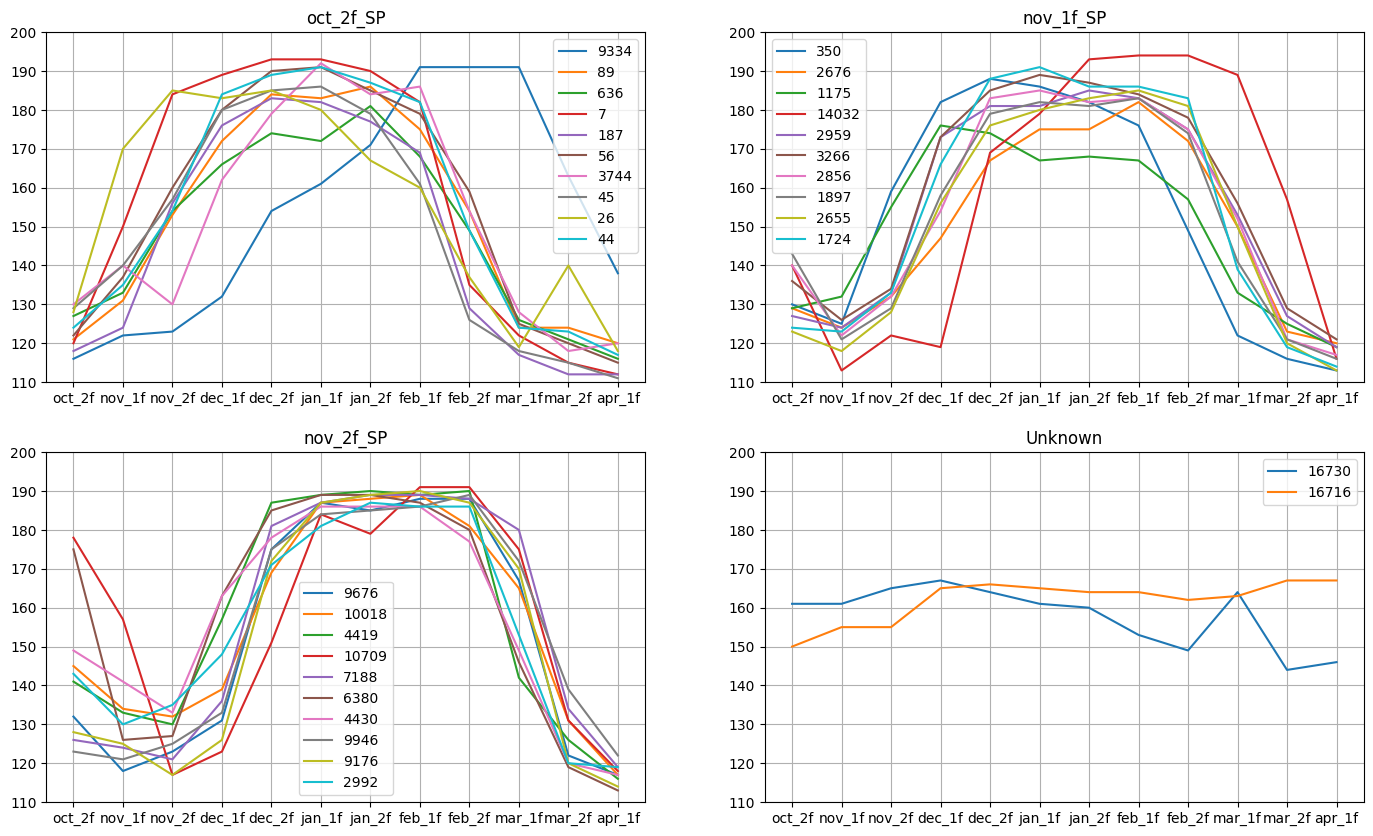

In [37]:
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,10))

plt.setp(axes,  xticks = np.arange(0,12,1), xticklabels = wheat.loc[:,'oct_2f':'apr_1f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

wheat[wheat.sowing_period == 'oct_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[0,0],
                                                                                         title='oct_2f_SP')
wheat[wheat.sowing_period == 'nov_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[0,1],
                                                                                         title='nov_1f_SP')
wheat[wheat.sowing_period == 'nov_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=0).T.plot(ax=axes[1,0],
                                                                                         title='nov_2f_SP')
wheat[wheat.sowing_period == 'Unknown'].loc[:,'oct_2f':'apr_1f'].sample(2, random_state=0).T.plot(ax=axes[1,1],
                                                                                         title='Unknown')

plt.show()

In [38]:
new_outliers = wheat[wheat.sowing_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

# Dropping the Unknown harvest labels
wheat.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', wheat.loc[:,'oct_2f':'apr_1f'].describe().T)

'2 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,16531.0,146.416309,16.684687,83.0,133.0,144.0,159.0,200.0
nov_1f,16531.0,129.657915,12.982059,93.0,120.0,126.0,136.0,190.0
nov_2f,16531.0,127.223701,9.356044,109.0,121.0,125.0,131.0,200.0
dec_1f,16531.0,141.737826,18.389882,110.0,127.0,136.0,156.0,200.0
dec_2f,16531.0,168.542435,16.162089,118.0,157.0,171.0,182.0,200.0
jan_1f,16531.0,181.834856,7.911516,153.5,177.0,183.0,188.0,200.0
jan_2f,16531.0,184.322062,5.443464,151.0,181.0,185.0,188.0,200.0
feb_1f,16531.0,186.728147,4.395498,141.0,184.0,187.0,190.0,200.0
feb_2f,16531.0,182.262477,10.559674,120.0,180.0,185.0,189.0,200.0
mar_1f,16531.0,164.590224,20.910705,89.0,149.0,172.0,181.0,200.0


__Determination of Harvest__

- Needs sowing period to determine harvest period.
- First fortnight value under 140 after Six fortnights or 3 months from the sowing period will be the first fortnight after harvest.

In [39]:
# Getting the harvest_period fortnight labels

def harvest_period(row):
    sowing_period_idx = row.index.get_loc(row['sowing_period'])
    i = sowing_period_idx + 6
    while i < len(row.loc[:'apr_1f']):
        if row[i] < 140:
            return row.index[i-1]
        i += 1
    return 'Unknown'

wheat['harvest_period'] = wheat.apply(harvest_period, axis=1)
wheat['harvest_year'] = [2023] * wheat.shape[0]

wheat.harvest_period.value_counts()

harvest_period
mar_1f     8394
mar_2f     5217
feb_2f     2525
Unknown     224
feb_1f      171
Name: count, dtype: int64

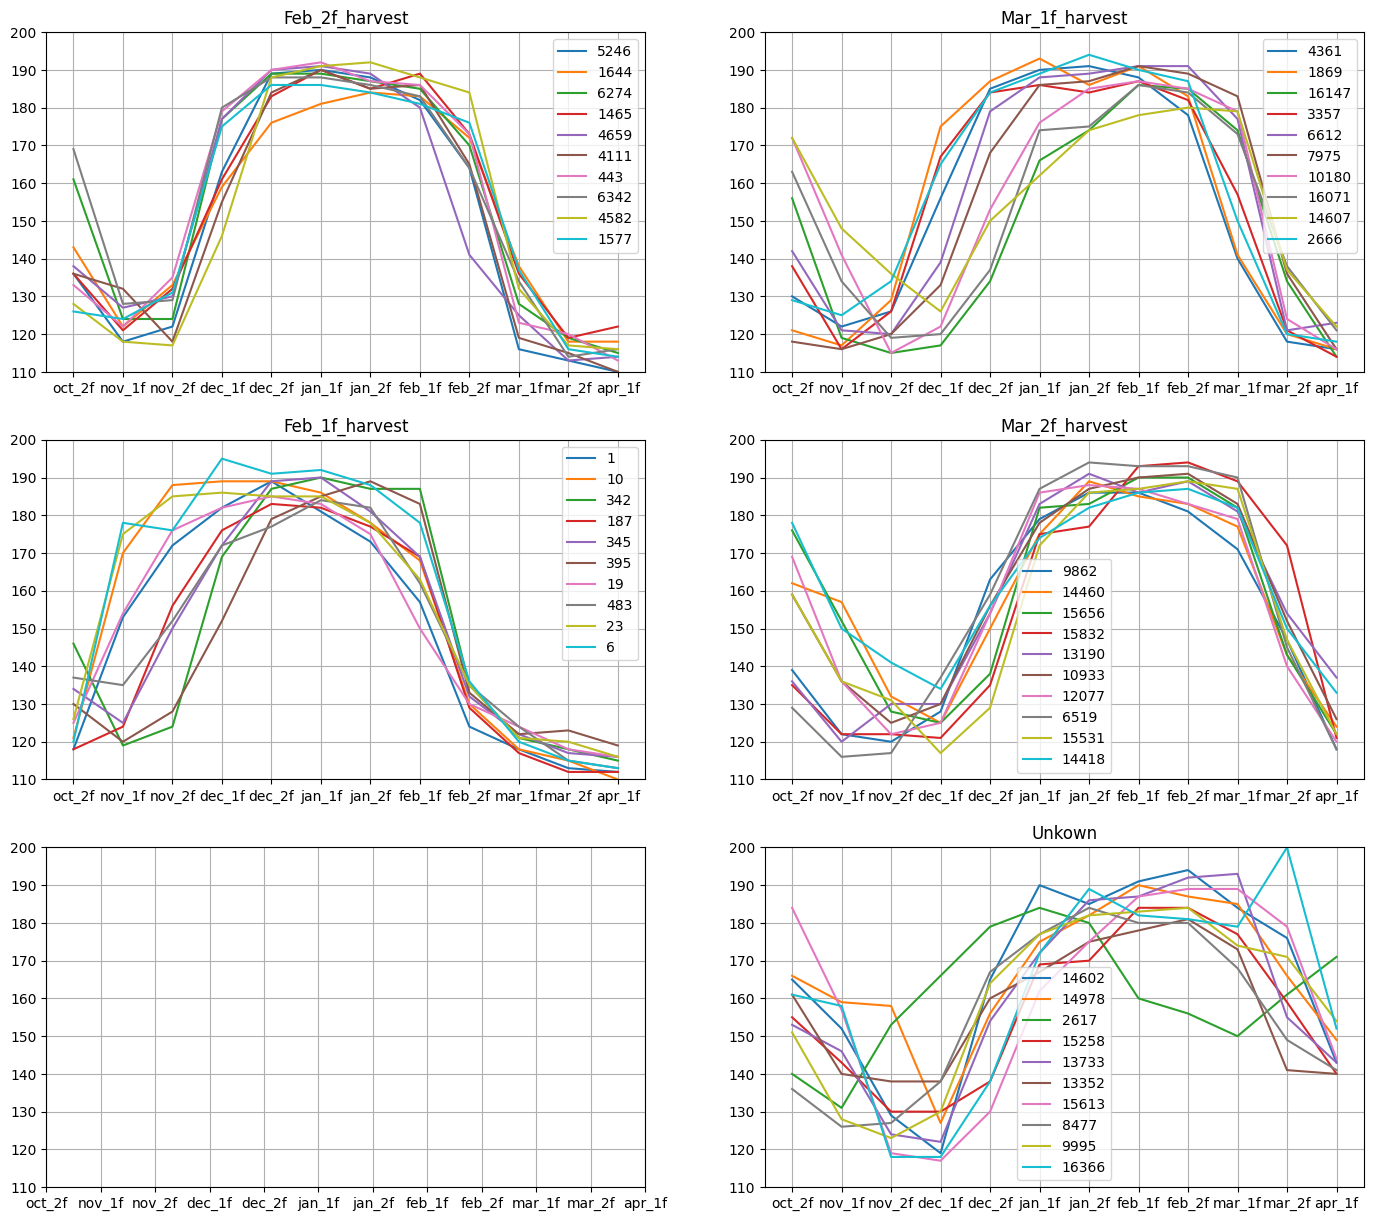

In [40]:
plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17,15))

plt.setp(axes,  xticks = np.arange(0,12,1), xticklabels = wheat.loc[:,'oct_2f':'apr_1f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

wheat[wheat.harvest_period == 'feb_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[0,0],
                                                                                         title='Feb_2f_harvest')
wheat[wheat.harvest_period == 'mar_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[0,1],
                                                                                         title='Mar_1f_harvest')
wheat[wheat.harvest_period == 'feb_1f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[1,0],
                                                                                         title='Feb_1f_harvest')
wheat[wheat.harvest_period == 'mar_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[1,1],
                                                                                         title='Mar_2f_harvest')
# wheat[wheat.harvest_period == 'jan_2f'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[2,0],
#                                                                                          title='Jan_2f_harvest')
wheat[wheat.harvest_period == 'Unknown'].loc[:,'oct_2f':'apr_1f'].sample(10, random_state=190).T.plot(ax=axes[2,1],
                                                                                         title='Unknown')

plt.show()

In [41]:
new_outliers = wheat[wheat.harvest_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

# Dropping the Unknown harvest labels
wheat.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped', wheat.loc[:,'oct_2f':'apr_1f'].describe().T)

'224 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,16307.0,146.249525,16.651196,83.0,133.0,144.0,159.0,200.0
nov_1f,16307.0,129.482370,12.872278,93.0,120.0,125.0,135.0,190.0
nov_2f,16307.0,127.154412,9.297788,109.0,121.0,125.0,131.0,200.0
dec_1f,16307.0,141.882566,18.436924,110.0,127.0,136.0,156.0,200.0
dec_2f,16307.0,168.722634,16.123721,118.0,158.0,171.0,182.0,200.0
jan_1f,16307.0,181.945177,7.858944,160.0,177.0,183.0,188.0,200.0
jan_2f,16307.0,184.368492,5.426373,151.0,181.0,185.0,188.0,200.0
feb_1f,16307.0,186.736248,4.388978,141.0,184.0,187.0,190.0,200.0
feb_2f,16307.0,182.206660,10.598529,120.0,180.0,185.0,189.0,200.0
mar_1f,16307.0,164.366898,20.939904,89.0,149.0,172.0,181.0,200.0


In [42]:
## Checking if there are rows which have max of NDVI values less than 150 for all the values between sp and hp.

def less_than_150_drop(row):
    sp_loc = row.index.get_loc(row['sowing_period'])
    hp_loc = row.index.get_loc(row['harvest_period'])
    if max(row.iloc[sp_loc+1:hp_loc]) < 150:
        return False
    return True    

new_outliers = wheat[wheat.apply(less_than_150_drop, axis=1) == False]
outliers = pd.concat([outliers, new_outliers])

wheat = wheat.drop(new_outliers.index)

display(f'{new_outliers.shape[0]} dropped', wheat.loc[:,'oct_2f':'apr_1f'].describe().T)

'0 dropped'

,count,mean,std,min,25%,50%,75%,max
oct_2f,16307.0,146.249525,16.651196,83.0,133.0,144.0,159.0,200.0
nov_1f,16307.0,129.482370,12.872278,93.0,120.0,125.0,135.0,190.0
nov_2f,16307.0,127.154412,9.297788,109.0,121.0,125.0,131.0,200.0
dec_1f,16307.0,141.882566,18.436924,110.0,127.0,136.0,156.0,200.0
dec_2f,16307.0,168.722634,16.123721,118.0,158.0,171.0,182.0,200.0
jan_1f,16307.0,181.945177,7.858944,160.0,177.0,183.0,188.0,200.0
jan_2f,16307.0,184.368492,5.426373,151.0,181.0,185.0,188.0,200.0
feb_1f,16307.0,186.736248,4.388978,141.0,184.0,187.0,190.0,200.0
feb_2f,16307.0,182.206660,10.598529,120.0,180.0,185.0,189.0,200.0
mar_1f,16307.0,164.366898,20.939904,89.0,149.0,172.0,181.0,200.0


# Pipeline to preprocess data

In [43]:
def data_preprocess(data):
    outliers = data[data.loc[:,'oct_2f':'dec_2f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]

    # Rows which have 0s or 1s in the 3 possible sowing periods for data are dropped
    data.drop(outliers.index, inplace=True)

    # Imputing the possible harvest fns with the average of its immediate neighbours
    data = data.apply(harvest_avg_impute, axis=1)
    
    new_outliers = data[data.loc[:,'jan_2f':'apr_1f'].apply(lambda row:any((i == 1)|(i == 0) for i in row), axis=1)]
    outliers = pd.concat([outliers, new_outliers])
    
    # if 0s and 1s still exit in the possible harvest periods, those rows are dropped
    data.drop(new_outliers.index, inplace=True)

    # Imputing the dec_1f, dec_2f and jan_1f fornights with the averages if the dip is not less than 30 from the adjs 
    data = data.apply(dip_impute, axis=1)

    # Sowing period determination
    data['sowing_period'] = data.apply(sowing_period, axis=1)
    data['sowing_year'] = [2022] * data.shape[0]
    
    new_outliers = data[data.sowing_period == 'Unknown']
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the Unknown sp labels
    data.drop(new_outliers.index, inplace=True)

    data['harvest_period'] = data.apply(harvest_period, axis=1)
    data['harvest_year'] = [2023] * data.shape[0]

    new_outliers = data[data.harvest_period == 'Unknown']
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the Unknown harvest labels
    data.drop(new_outliers.index, inplace=True)

    new_outliers = data[data.apply(less_than_150_drop, axis=1) == False]
    outliers = pd.concat([outliers, new_outliers])
    
    # Dropping the rows which have max of NDVI values less than 150 for all the values between sp and hp.
    data = data.drop(new_outliers.index)

    display(data.head(3), data.shape)

    return data, outliers

# New wheat

In [44]:
def new_GT_initial_preprocess():
    
    files = np.array(glob(r'data_files/new+old/new/Point/**/*.xlsx', recursive=True))

    series = pd.Series(pd.read_excel(files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    std_columns = ['latitude', 'longitude', 'state_name', 'district', 
                        'taluka_name', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 
                        'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 
                        'mar_2f', 'apr_1f', 'crop_name']
    
    wheat = pd.DataFrame(columns = std_columns)

    for file in files:
        raw = pd.read_excel(file)
        wheat_sample = pd.DataFrame(columns = std_columns)
        wheat_sample['longitude'] = raw['geometry'].apply(lambda row:float(row.split(' ')[1][1:])/10000)
        wheat_sample['latitude'] = raw['geometry'].apply(lambda row:float(row.split(' ')[-1][:-1])/100000)
        wheat_sample[['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f']] = raw[ndvi_cols[1:13]]
        if 'Wheat' in file:
            if 'Shivpuri' in file:
                wheat_sample['taluka_name'] = ['SHIVPURI'] * wheat_sample.shape[0]
            else:
                wheat_sample['taluka_name'] = ['KARERA'] * wheat_sample.shape[0]
            wheat = pd.concat([wheat, wheat_sample],ignore_index=True)
            
    wheat.loc[:,'oct_2f':'apr_1f'] = wheat.loc[:,'oct_2f':'apr_1f'].apply(lambda row:round(row*100+100))
    wheat['district']=['SHIVPURI']*wheat.shape[0]
    wheat['state_name']=['Madhya Pradesh']*wheat.shape[0]
    wheat['crop_name'] =  ['Wheat'] * wheat.shape[0]
    
    return wheat

# Initial preprocessing of wheat
new_wheat= new_GT_initial_preprocess()

display(new_wheat.head(3), new_wheat.shape)

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name
0,28.498473,81.963412,Madhya Pradesh,SHIVPURI,KARERA,178.0,152.0,124.0,125.0,136.0,161.0,169.0,183.0,184.0,182.0,165.0,125.0,Wheat
1,28.489493,81.951411,Madhya Pradesh,SHIVPURI,KARERA,176.0,157.0,141.0,136.0,123.0,148.0,160.0,185.0,187.0,187.0,177.0,141.0,Wheat
2,28.498130,81.877915,Madhya Pradesh,SHIVPURI,KARERA,165.0,141.0,133.0,135.0,156.0,169.0,175.0,187.0,189.0,186.0,173.0,129.0,Wheat


(7514, 18)

In [45]:
new_wheat, new_outliers = data_preprocess(new_wheat)

outliers = pd.concat([outliers, new_outliers])

,latitude,longitude,state_name,district,taluka_name,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,...,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,crop_name,sowing_period,sowing_year,harvest_period,harvest_year
0,28.498473,81.963412,Madhya Pradesh,SHIVPURI,KARERA,178.0,152.0,124.0,125.0,136.0,...,183.0,184.0,182.0,165.0,125.0,Wheat,dec_1f,2022,mar_2f,2023
2,28.498130,81.877915,Madhya Pradesh,SHIVPURI,KARERA,165.0,141.0,133.0,135.0,156.0,...,187.0,189.0,186.0,173.0,129.0,Wheat,dec_1f,2022,mar_2f,2023
4,28.485848,82.007243,Madhya Pradesh,SHIVPURI,KARERA,173.0,136.0,127.0,127.0,139.0,...,186.0,186.0,185.0,170.0,130.0,Wheat,dec_1f,2022,mar_2f,2023


(5760, 22)

# File Export for Modelling

In [46]:
wheat.to_csv(r'data_files/data_share/preprocessed_wheat.csv', index=False)
new_wheat.to_csv(r'data_files/data_share/preprocessed_new_wheat.csv', index=False)

# File Export for Data Ingestion

In [47]:
wheat = pd.concat([wheat, new_wheat], ignore_index=True)

In [48]:
ingest_order = ['latitude', 'longitude', 'state_name', 'district', 'taluka_name', 'sowing_period', 'crop_name',
                'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f', 'oct_2f', 'nov_1f', 
                'nov_2f', 'dec_1f', 'dec_2f', 'sowing_year', 'harvest_year', 'harvest_period']

wheat = wheat[ingest_order]

In [49]:
new_columns = ['apr_2f', 'may_1f', 'may_2f', 'jun_1f', 'jun_2f', 'jul_1f', 'jul_2f', 'aug_1f', 'aug_2f', 
               'sep_1f', 'sep_2f', 'oct_1f']

i = 12
for cols in new_columns:
    wheat.insert(i, cols, [np.nan]*wheat.shape[0])
    i += 1
    
wheat.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,crop_name,jan_1f,jan_2f,feb_1f,...,mar_2f,apr_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,sowing_year,harvest_year,harvest_period
0,23.221024,75.548143,Madhya Pradesh,UJJAIN,NaN,oct_2f,Wheat,191.0,185.0,177.0,...,114.0,120.0,117.0,154.0,185.0,186.0,191.0,2022,2023,feb_1f
1,22.749243,76.285961,Madhya Pradesh,DEWAS,NaN,oct_2f,Wheat,181.0,173.0,157.0,...,113.0,112.0,118.0,153.0,172.0,182.0,189.0,2022,2023,feb_1f
2,22.823677,75.178438,Madhya Pradesh,DHAR,NaN,oct_2f,Wheat,191.0,178.0,144.0,...,113.0,114.0,119.0,159.0,186.0,190.0,193.0,2022,2023,feb_1f


In [50]:
NDVI_bands = ['jan_1f','jan_2f', 'feb_1f', 'feb_2f', 'mar_1f','mar_2f', 'apr_1f', 'apr_2f', 'may_1f','may_2f', 
              'jun_1f', 'jun_2f', 'jul_1f', 'jul_2f', 'aug_1f', 'aug_2f', 'sep_1f', 'sep_2f', 'oct_1f', 'oct_2f', 
              'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f']

wheat = wheat.melt(id_vars =['latitude', 'longitude', 'state_name', 'district', 'taluka_name', 'sowing_period', 
                             'sowing_year', 'harvest_period', 'harvest_year', 'crop_name'],
                               value_vars = NDVI_bands, var_name = 'ndvi_capture_period', value_name='ndvi_value')

wheat = wheat[['latitude', 'longitude', 'state_name', 'district', 'taluka_name','sowing_period',
              'crop_name', 'ndvi_capture_period', 'ndvi_value', 'sowing_year', 'harvest_year', 'harvest_period']]

wheat.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,crop_name,ndvi_capture_period,ndvi_value,sowing_year,harvest_year,harvest_period
0,23.221024,75.548143,Madhya Pradesh,UJJAIN,NaN,oct_2f,Wheat,jan_1f,191.0,2022,2023,feb_1f
1,22.749243,76.285961,Madhya Pradesh,DEWAS,NaN,oct_2f,Wheat,jan_1f,181.0,2022,2023,feb_1f
2,22.823677,75.178438,Madhya Pradesh,DHAR,NaN,oct_2f,Wheat,jan_1f,191.0,2022,2023,feb_1f


In [51]:
wheat.insert(6, 'year', [np.nan] * wheat.shape[0])
wheat.insert(10, 'location', [np.nan] * wheat.shape[0])
wheat.insert(11, 'ndvi_capture_date', [np.nan] * wheat.shape[0])
wheat.insert(12, 'interval_range', [np.nan] * wheat.shape[0])
wheat.insert(14, 'sowing_date', [np.nan] * wheat.shape[0])

wheat.head(3)

,latitude,longitude,state_name,district,taluka_name,sowing_period,year,crop_name,ndvi_capture_period,ndvi_value,location,ndvi_capture_date,interval_range,sowing_year,sowing_date,harvest_year,harvest_period
0,23.221024,75.548143,Madhya Pradesh,UJJAIN,NaN,oct_2f,NaN,Wheat,jan_1f,191.0,NaN,NaN,NaN,2022,NaN,2023,feb_1f
1,22.749243,76.285961,Madhya Pradesh,DEWAS,NaN,oct_2f,NaN,Wheat,jan_1f,181.0,NaN,NaN,NaN,2022,NaN,2023,feb_1f
2,22.823677,75.178438,Madhya Pradesh,DHAR,NaN,oct_2f,NaN,Wheat,jan_1f,191.0,NaN,NaN,NaN,2022,NaN,2023,feb_1f


In [54]:
def find_tehsil(coordinates, shape_file_path):
    # Create a list of Point objects from the coordinates
    points = [Point(lon, lat) for lat, lon in coordinates]

    # Create a GeoDataFrame with the location points
    gdf = gp.GeoDataFrame({"location": points}, geometry='location')
    shp_file = gp.read_file(shape_file_path)
    
    gdf.crs = "epsg:4326"
    gdf.to_crs("WGS84", inplace=True)
    
    shp_file.to_crs("WGS84", inplace=True)
    
    latlong_with_talukas = gp.sjoin(gdf, shp_file, how='left', predicate='within')
    # # Identify the values that are not mapped (don't have matches)
    # not_mapped = gdf[~gdf.index.isin(latlong_with_talukas.index)]
    # print(not_mapped)
    
    upper_case_talukas = latlong_with_talukas['Tehsil_1'].apply(lambda taluka: str(taluka).upper()).to_numpy()
    return upper_case_talukas

wheat['taluka_name'] = find_tehsil(wheat[['latitude', 'longitude']].values, 'data_files/sub_district/SUBDISTRICT_BOUNDARY.shp')
wheat['taluka_name'] = wheat['taluka_name'].apply(lambda taluka: np.nan if taluka == 'NAN' else taluka)

In [55]:
wheat = wheat.loc[wheat['taluka_name'].dropna().index]

In [56]:
wheat.to_csv(r'data_files\data_share\wheat_for_ingestion.csv', index=False)